# Biosignal Visualization Lab #1

Author: Davide Marzorati

Date: 20/02/2024

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy.io
import scipy.signal
import seaborn as sns

## Exercise 1
Aim: Visualize a tachogram, compute heart rate based on RR intervals and qualitatively analyze the relation of heart rate with sleep

### Load BBI
The bbi.csv file contains two columns:


*   isoDate: timestamp of a sample
*   bbi: beat-to-beat interval value

In order to properly plot the BBI, we first need to change the format of the isoDate column to a datetime format, using the `pd.to_datetime` function.




In [ ]:
# Replace ROOT_FOLDER with path to your "1.2 - Biosignal Visualization #1" folder
# in the main _DATA folder
ROOT_FOLDER = Path('/gdrive') / "MyDrive" / "_BSP-Group" / "teaching" / "Applied Case Studies" / "2024" / "Slides and Data" / "_Data" / "1.2 - Biosignal Visualization #1"
# Set path of bbi.csv file
BBI_PATH = ROOT_FOLDER / "bbi.csv"
# Load bbi data
bbi = pd.read_csv(BBI_PATH)

In [ ]:
bbi.head()

,isoDate,bbi
0,2023-05-30 10:24:05.470,664
1,2023-05-30 10:24:06.133,712
2,2023-05-30 10:24:07.744,690
3,2023-05-30 10:24:08.434,709
4,2023-05-30 10:24:09.143,694


### Plot tachogram

In [ ]:
# Convert isoDate from string to datetime
bbi["isoDate"] = pd.to_datetime(bbi["isoDate"])

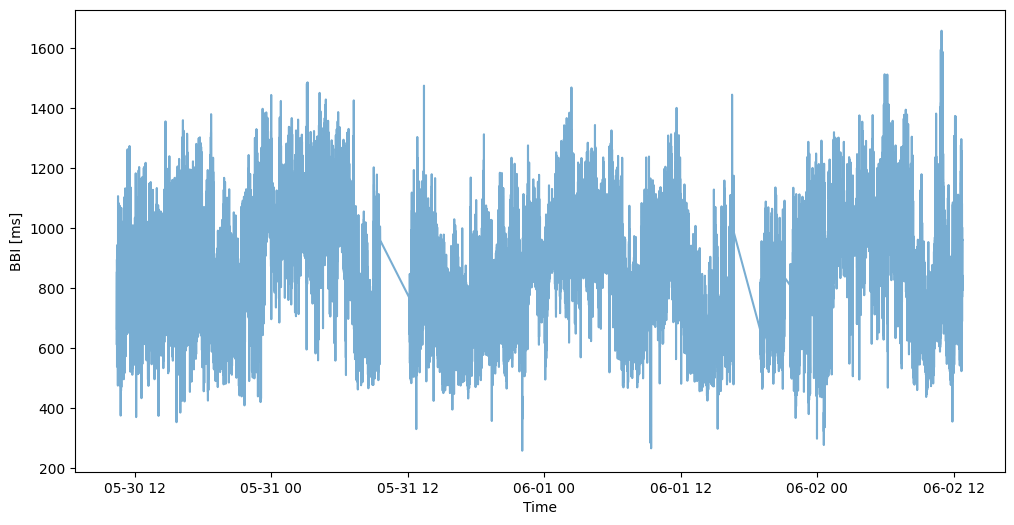

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(bbi.isoDate, bbi.bbi, alpha=0.6, c='tab:blue')
plt.xlabel('Time')
plt.ylabel('BBI [ms]');

### Convert to Heart Rate
In order to convert BBI to heart-rate, we need to consider that:


1.   beat-to-beat intervals are expressed in milliseconds
2.   heart-rate is expressed in beats per minute

Thus, heart-rate is equal to:
HR = 1/(BBI/1000)*60

In [ ]:
bbi["beatsPerMinute"] = 1/(bbi["bbi"]/1000)*60

### Plot Heart Rate

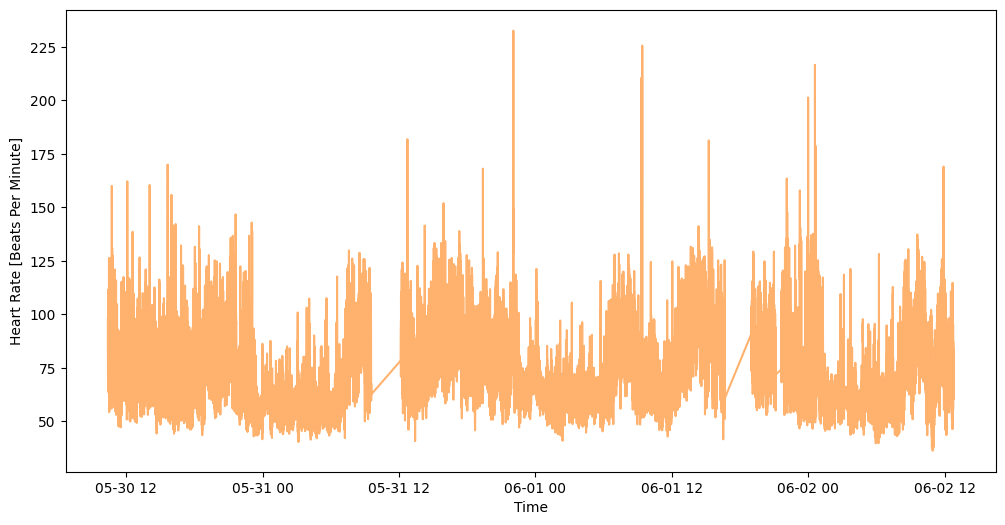

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(bbi.isoDate, bbi.beatsPerMinute, alpha=0.6, c='tab:orange')
plt.xlabel('Time')
plt.ylabel('Heart Rate [Beats Per Minute]');

### Add sleep information
The sleeps_summary.csv file contains three columns:


*   calendarDate, which is the date to which sleep refers to
*   bedtime, which is the datetime at which the subject went to bed
*   wakeup, which is the datetime at which the subject woke up



In [ ]:
# Set path to sleep_summary file
SLEEP_PATH = Path(ROOT_FOLDER) / "sleep_summary.csv"
# Read sleep summary file
sleep = pd.read_csv(SLEEP_PATH)
# Convert calendarDate, bedtime, and wakeup to datetime
sleep["calendarDate"] = pd.to_datetime(sleep["calendarDate"])
sleep["bedtime"] = pd.to_datetime(sleep["bedtime"])
sleep["wakeup"] = pd.to_datetime(sleep["wakeup"])

In [ ]:
sleep.head()

,calendarDate,bedtime,wakeup
0,2023-05-30,2023-05-29 22:52:00,2023-05-30 05:54:00
1,2023-05-31,2023-05-30 23:29:00,2023-05-31 07:15:00
2,2023-06-01,2023-05-31 22:50:00,2023-06-01 06:30:00
3,2023-06-02,2023-06-02 01:39:00,2023-06-02 08:03:00


We iterate over each row and, based on the value of bedtime and wakeup, we set a boolean column to True if sleep was detected, and we also add
calendarDate information.

In [ ]:
bbi["sleep"] = False
for idx, row in sleep.iterrows():
  bbi.loc[(bbi["isoDate"]>=row["bedtime"]) & (bbi["isoDate"]<=row["wakeup"]), "sleep"] = True
  bbi.loc[(bbi["isoDate"]>=row["bedtime"]) & (bbi["isoDate"]<=row["wakeup"]), "calendarDate"] = row["calendarDate"]
bbi.loc[bbi["calendarDate"].isna(), "calendarDate"] = bbi["isoDate"].dt.date

### Plot with sleep

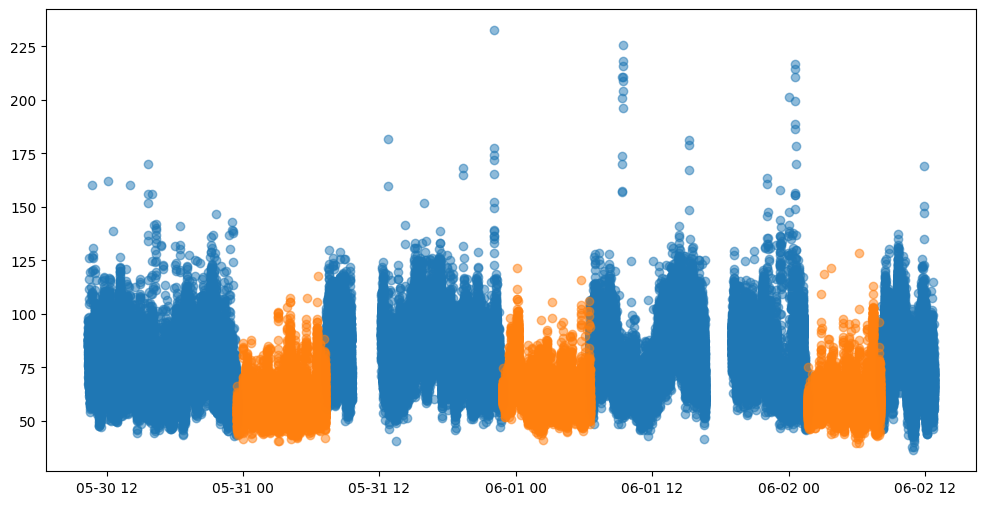

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(bbi[bbi["sleep"]==False]["isoDate"], bbi[bbi["sleep"]==False]["beatsPerMinute"], 'o', c="tab:blue", alpha=0.5)
plt.plot(bbi[bbi["sleep"]==True]["isoDate"], bbi[bbi["sleep"]==True]["beatsPerMinute"], 'o', c="tab:orange", alpha=0.5);

### Statistics based on Sleep

In [ ]:
bbi.groupby(["calendarDate", "sleep"]).beatsPerMinute.mean()

calendarDate  sleep
2023-05-30    False    75.332058
2023-05-31    False    83.358108
              True     58.495347
2023-06-01    False    81.106744
              True     63.647893
2023-06-02    False    80.350405
              True     59.680009
Name: beatsPerMinute, dtype: float64

In [ ]:
bbi.groupby(["calendarDate", "sleep"]).beatsPerMinute.std()

calendarDate  sleep
2023-05-30    False    12.618733
2023-05-31    False    12.583517
              True      6.316612
2023-06-01    False    14.481918
              True      6.413491
2023-06-02    False    14.936782
              True      5.260734
Name: beatsPerMinute, dtype: float64

## Exercise 2
Aim: Visualize an EEG evoked potential, average it across epochs and show difference between target/non-target events

### Load Data
The epochs.csv file contains one column per each EEG channel, and one column with information about the epoch index, which corresponds to a single row of the stim_info.csv file -> we have one epoch per each row in stim_info.csv. If the correspondent row in stim_info.csv has a stimulusType of 1, then it is target (so, expected P300), otherwise it is non-target (no P300 expected).
One epoch has a duration of 1 second, thus 250 samples (considering that the sampling frequency is of 250 Hz)

In [ ]:
P300_PATH = Path(ROOT_FOLDER) / "epochs.csv"
STIM_INFO_PATH = Path(ROOT_FOLDER) / "stim_info.csv"
epochs = pd.read_csv(P300_PATH)
stim_info = pd.read_csv(STIM_INFO_PATH)

epochs = epochs.drop(["epochIndex"], axis=1)

In [ ]:
epochs.head()

,C3,C4,P3,P4,P7,P8,Pz,Oz
0,-0.862375,1.826999,-5.801232,-2.248161,-0.986847,7.130816,6.998917,0.926173
1,-4.324396,0.908599,-7.496821,-4.621965,-2.213520,3.951427,4.013785,-2.739020
2,-6.604131,0.579270,-9.814248,-6.673952,-3.565965,2.120853,2.272935,-5.405247
3,-7.415565,1.493449,-11.922694,-7.914206,-4.288769,1.762817,1.916799,-6.739188
4,-7.372628,3.695211,-12.757460,-8.056681,-3.876325,2.235980,2.380201,-7.233790


In [ ]:
stim_info.head()

,stimulusType,triggerInfo
0,0,3700
1,0,3767
2,0,3834
3,0,3905
4,1,3968


### Compute mean epochs

In [ ]:
# Average across all channels -> set up arrays
grand_t_average = np.zeros((250,))
grand_nt_average = np.zeros((250,))
# Average for each channel -> set up arrays
epochs_t_average = np.zeros((250, 8))
epochs_nt_average = np.zeros((250, 8))
# Counter for targets and non targets
targets = 0
n_targets = 0

for i in range(len(stim_info)):
    # Compute averages
    if(stim_info.loc[i,"stimulusType"] == 1):
      # We are expecting a P300, thus use target average
      targets += 1
      epochs_t_average = epochs_t_average + epochs.iloc[i*250:(i+1)*250].to_numpy()
      grand_t_average = grand_t_average + epochs.iloc[i*250:(i+1)*250].to_numpy().mean(axis=1)
    else:
      n_targets += 1
      epochs_nt_average = epochs_nt_average + epochs.iloc[i*250:(i+1)*250].to_numpy()
      grand_nt_average = grand_nt_average + epochs.iloc[i*250:(i+1)*250].to_numpy().mean(axis=1)

### Plot per-channel mean

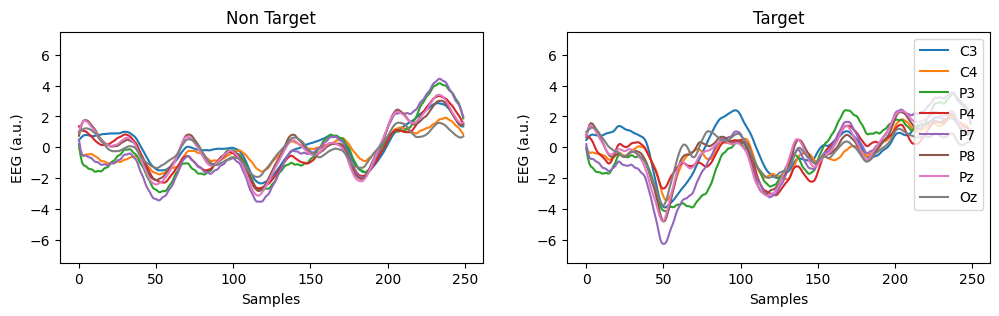

In [ ]:
plt.subplots(1,2,figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(-epochs_nt_average/n_targets)
plt.title('Non Target')
plt.xlabel('Samples')
plt.ylabel('EEG (a.u.)')
plt.ylim([-7.5, 7.5])
plt.subplot(1,2,2)
plt.plot(-epochs_t_average/targets)
plt.title('Target')
plt.xlabel('Samples')
plt.ylabel('EEG (a.u.)')
plt.ylim([-7.5, 7.5])
plt.legend(epochs.columns);


### Plot grand means

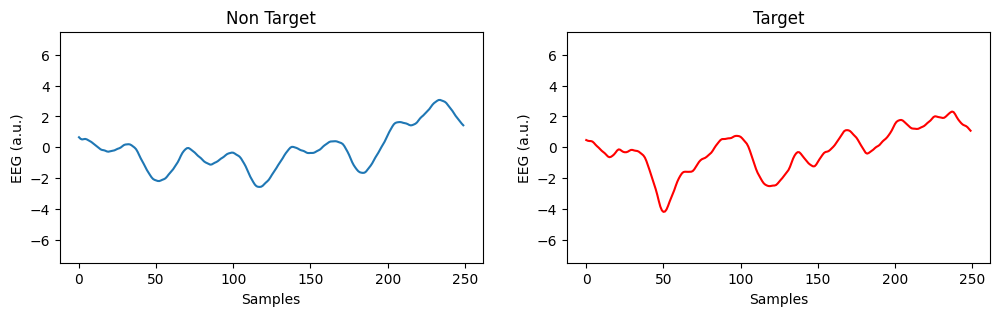

In [ ]:
plt.subplots(1,2,figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(-grand_nt_average/n_targets)
plt.title('Non Target')
plt.xlabel('Samples')
plt.ylabel('EEG (a.u.)')
plt.ylim([-7.5, 7.5])
plt.subplot(1,2,2)
plt.plot(-grand_t_average/targets, 'r')
plt.title('Target')
plt.xlabel('Samples')
plt.ylabel('EEG (a.u.)')
plt.ylim([-7.5, 7.5]);

### 2.2
Now that we know the concept of sampling frequency, let's now plot the average epochs again with the proper information on the x-axis: epochs are from -100ms to +900 ms with respect to the stimulust onset: do the P300 really shows at 300 ms after the stimulus onset

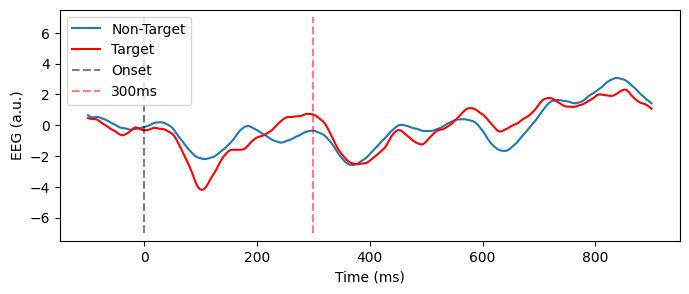

In [ ]:
plt.subplots(1,1,figsize=(8,3))
plt.plot(np.linspace(-100, 900, 250),-grand_nt_average/n_targets, label='Non-Target')
plt.plot(np.linspace(-100, 900, 250),-grand_t_average/targets, 'r', label='Target')
plt.vlines(0, -7, 7, linestyles='--', color='k', alpha=0.5, label='Onset')
plt.vlines(300, -7, 7, linestyles='--', color='r', alpha=0.5, label='300ms')
plt.ylabel('EEG (a.u.)')
plt.ylim([-7.5, 7.5])
plt.xlabel('Time (ms)')
plt.legend();
